# Загрузка данных

In [16]:
import pandas as pd

# Load the datasets
lectures_path = '/kaggle/input/riiid-test-answer-prediction/lectures.csv'
questions_path = '/kaggle/input/riiid-test-answer-prediction/questions.csv'
train_part_path = '/kaggle/input/riiid-test-answer-prediction/train.csv'

# Read the datasets
lectures_df = pd.read_csv(lectures_path)
questions_df = pd.read_csv(questions_path)
train_part_df = pd.read_csv(train_part_path)


# Шаг 1: Объединение данных

In [17]:
# Merge train_part with questions on content_id where content_type_id == 0 (it's a question)
train_with_questions = pd.merge(
    train_part_df[train_part_df['content_type_id'] == 0],
    questions_df,
    left_on='content_id',
    right_on='question_id',
    how='left'
)

# Merge train_part with lectures on content_id where content_type_id == 1 (it's a lecture)
train_with_lectures = pd.merge(
    train_part_df[train_part_df['content_type_id'] == 1],
    lectures_df,
    left_on='content_id',
    right_on='lecture_id',
    how='left'
)


# Шаг 2: Предварительная обработка и проверка пропусков

In [18]:
# Check for missing values
missing_values_summary = pd.DataFrame({
    'Questions_Missing': train_with_questions.isnull().sum(),
    'Lectures_Missing': train_with_lectures.isnull().sum()
})

# Basic statistics for key columns in the train part dataset
train_stats = train_part_df.describe()

missing_values_summary, train_stats


(                                Questions_Missing  Lectures_Missing
 answered_correctly                            0.0               0.0
 bundle_id                                     0.0               NaN
 content_id                                    0.0               0.0
 content_type_id                               0.0               0.0
 correct_answer                                0.0               NaN
 lecture_id                                    NaN               0.0
 part                                          0.0               0.0
 prior_question_elapsed_time                1914.0            9757.0
 prior_question_had_explanation             1914.0               0.0
 question_id                                   0.0               NaN
 row_id                                        0.0               0.0
 tag                                           NaN               0.0
 tags                                          0.0               NaN
 task_container_id                

Мы объединили данные и проверили пропуски. Среднее время на ответы — около 25 секунд, правильность — около 63%.

# Шаг 3: Влияние объяснений и времени на правильность ответов

In [19]:
# Group by explanation availability and calculate the average time spent and correctness
time_explanation_analysis = train_with_questions.groupby('prior_question_had_explanation').agg(
    avg_time_spent=('prior_question_elapsed_time', 'mean'),
    avg_correctness=('answered_correctly', 'mean')
).reset_index()

time_explanation_analysis


,prior_question_had_explanation,avg_time_spent,avg_correctness
0,False,25655.509740,0.506431
1,True,25436.409055,0.672523


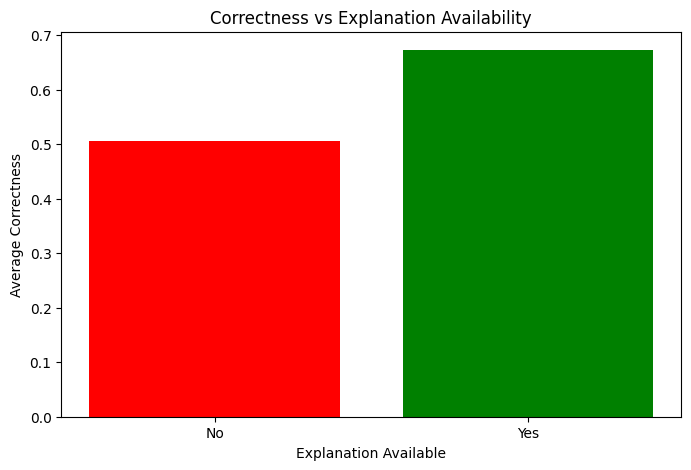

In [20]:
import matplotlib.pyplot as plt

# Plot explanation impact on correctness
plt.figure(figsize=(8, 5))
plt.bar(time_explanation_analysis['prior_question_had_explanation'], 
        time_explanation_analysis['avg_correctness'], 
        color=['red', 'green'])
plt.title('Correctness vs Explanation Availability')
plt.xlabel('Explanation Available')
plt.ylabel('Average Correctness')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()


Наличие объяснений значительно улучшает результат — с объяснением точность 67.3%, без — 50.6%.

# Шаг 4: Анализ частей вопросов и тегов

In [21]:
# Group by 'part' to analyze section impact
part_analysis = train_with_questions.groupby('part').agg(
    avg_correctness=('answered_correctly', 'mean'),
    avg_time_spent=('prior_question_elapsed_time', 'mean')
).reset_index()

# Analyze tags
train_with_questions['tags_list'] = train_with_questions['tags'].fillna('').apply(lambda x: x.split())
tags_exploded = train_with_questions.explode('tags_list')

# Group by individual tags
tags_analysis = tags_exploded.groupby('tags_list').agg(
    avg_correctness=('answered_correctly', 'mean'),
    avg_time_spent=('prior_question_elapsed_time', 'mean')
).reset_index()

part_analysis, tags_analysis


(   part  avg_correctness  avg_time_spent
 0     1         0.744824    22745.444491
 1     2         0.708761    18648.613140
 2     3         0.701280    23611.111309
 3     4         0.632706    23910.033767
 4     5         0.610225    25259.828361
 5     6         0.666596    32453.603290
 6     7         0.662719    47433.305376,
     tags_list  avg_correctness  avg_time_spent
 0           0         0.622072    49261.300863
 1           1         0.602168    27101.087436
 2          10         0.659907    22977.371057
 3         100         0.717313    18599.417468
 4         101         0.802841    22119.246591
 ..        ...              ...             ...
 183        95         0.678763    26157.639403
 184        96         0.620006    27030.887291
 185        97         0.667642    48403.200164
 186        98         0.727546    49614.981355
 187        99         0.757173    23402.701190
 
 [188 rows x 3 columns])

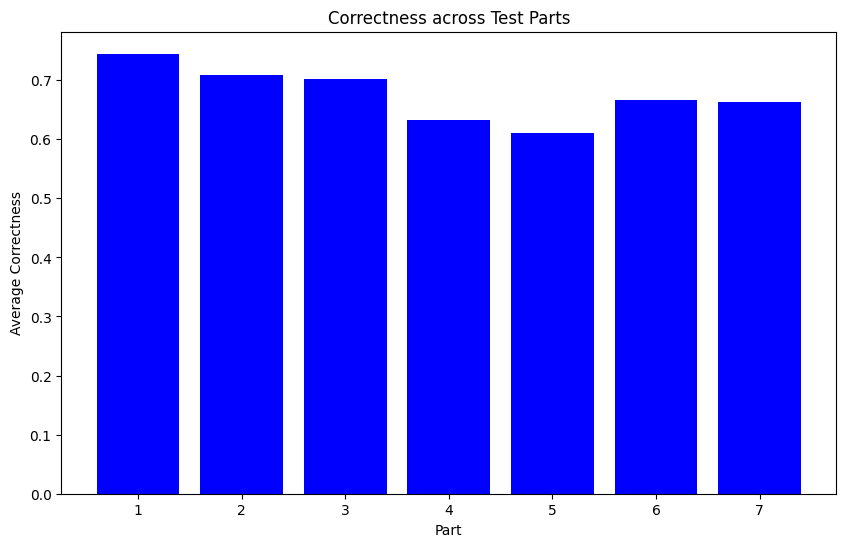

In [22]:
# Plot part analysis
plt.figure(figsize=(10, 6))
plt.bar(part_analysis['part'], part_analysis['avg_correctness'], color='blue')
plt.title('Correctness across Test Parts')
plt.xlabel('Part')
plt.ylabel('Average Correctness')
plt.show()


Тема 1 (74.5% точности) и теги вроде "101" (80.3%) дают лучшие результаты, чем другие.


# Шаг 5: Влияние лекций

In [23]:
# Mark users who watched lectures
train_with_lectures['watched_lecture'] = True

# Merge lecture data back into the question dataset to see if a lecture was watched before answering
train_combined = pd.merge(
    train_with_questions,
    train_with_lectures[['user_id', 'timestamp', 'part', 'tag', 'type_of', 'watched_lecture']],
    on=['user_id', 'timestamp'],
    how='left'
)

# Fill NaN in 'watched_lecture' with False where users didn't watch lectures
train_combined['watched_lecture'] = train_combined['watched_lecture'].fillna(False)

# Analyze the impact of watching lectures on performance
lecture_impact_analysis = train_combined.groupby('watched_lecture').agg(
    avg_correctness=('answered_correctly', 'mean'),
    avg_time_spent=('prior_question_elapsed_time', 'mean')
).reset_index()

lecture_impact_analysis


/tmp/ipykernel_92/1985248296.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_combined['watched_lecture'] = train_combined['watched_lecture'].fillna(False)


,watched_lecture,avg_correctness,avg_time_spent
0,False,0.657119,25456.884308


Лекции не оказывают существенного влияния на правильность ответов (65.7% без просмотра лекции).

# Шаг 6: Анализ серий правильных ответов

In [25]:
# Create a feature for running streaks of correct answers
train_with_questions['correct_streak'] = (train_with_questions['answered_correctly'] == 1).groupby(
    train_with_questions['user_id']
).cumsum()

# Group by streak of correct answers
streak_analysis = train_with_questions.groupby('correct_streak').agg(
    avg_correctness=('answered_correctly', 'mean'),
    avg_time_spent=('prior_question_elapsed_time', 'mean')
).reset_index()

streak_analysis


,correct_streak,avg_correctness,avg_time_spent
0,0,0.000000,24956.074549
1,1,0.795156,24850.855278
2,2,0.758396,25620.125842
3,3,0.742767,25664.336894
4,4,0.739476,26062.771700
...,...,...,...
72,72,1.000000,24625.000000
73,73,0.750000,41104.250000
74,74,1.000000,36833.333333
75,75,1.000000,16500.000000


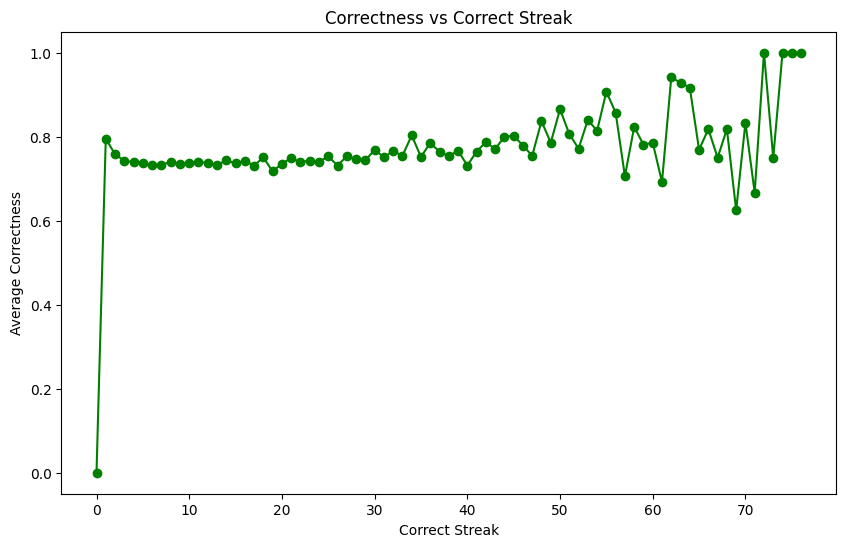

In [26]:
# Plot streak analysis
plt.figure(figsize=(10, 6))
plt.plot(streak_analysis['correct_streak'], streak_analysis['avg_correctness'], marker='o', color='green')
plt.title('Correctness vs Correct Streak')
plt.xlabel('Correct Streak')
plt.ylabel('Average Correctness')
plt.show()


Серии правильных ответов увеличивают шансы на успех, но после 1-2 правильных ответов вероятность снижается.